In [1]:
import numpy as np
import pickle
import cv2
import tensorflow
import seaborn as sn
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.applications import MobileNet
from keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
EPOCHS = 25
INIT_LR = 0.001
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = 'D:\\KULIAH\\SKRIPSI\\Dataset'
width=224
height=224
depth=3
num_folds = 5

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
           
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float32) / 225.0

In [9]:
print("[INFO] Splitting data to train, test")
X_train, X_test, Y_train, Y_test = train_test_split(np_image_list, image_labels, test_size=0.1, random_state = 42) 

[INFO] Splitting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [11]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [12]:
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1
for train, val in kfold.split(X_train, Y_train):
    print(f'Training for fold {fold_no} ...')
    X_train_cv, X_val_cv = X_train[train], X_train[val]
    Y_train_cv, Y_val_cv = Y_train[train], Y_train[val]
    
    # Define your model here and compile it
    # Create the base model of MobileNet
    model = MobileNet(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    # Freeze the layers
    for layer in model.layers:
        layer.trainable = False

    # Add new layers
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=model.input, outputs=predictions)
    
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
    
    # Train the model 
    history = model.fit(
        aug.flow(X_train_cv, Y_train_cv, batch_size=BS),
        validation_data=(X_val_cv, Y_val_cv),
        steps_per_epoch=len(X_train_cv) // BS,
        epochs=EPOCHS, verbose=1,
        callbacks=[early_stopping])

    # Generate generalization metrics
    scores = model.evaluate(X_val_cv, Y_val_cv, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print('------------------------------------------------------------------------')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    
    fold_no += 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Validation Loss: {loss_per_fold[i]} - Validation Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Validation Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Training for fold 1 ...
Epoch 1/25
25/25 [==============================] - 22s 812ms/step - loss: 1.2043 - accuracy: 0.6030 - val_loss: 0.4431 - val_accuracy: 0.8125
Epoch 2/25
25/25 [==============================] - 20s 805ms/step - loss: 0.4958 - accuracy: 0.8191 - val_loss: 0.2646 - val_accuracy: 0.8990
Epoch 3/25
25/25 [==============================] - 20s 804ms/step - loss: 0.3088 - accuracy: 0.8756 - val_loss: 0.3162 - val_accuracy: 0.8702
Epoch 4/25
25/25 [==============================] - 20s 799ms/step - loss: 0.2518 - accuracy: 0.8982 - val_loss: 0.2108 - val_accuracy: 0.9231
Epoch 5/25
25/25 [==============================] - 20s 803ms/step - loss: 0.2143 - accuracy: 0.9271 - val_loss: 0.2061 - val_accuracy: 0.9375
Epoch 6/25
25/25 [==============================] - 20s 790ms/step - loss: 0.1723 - accuracy: 0.9372 - val_loss: 0.2101 - val_accuracy: 0.9231
Epoch 7/25
25/25 [==============================] - 20s 800ms/step - loss: 0.1672 - accuracy: 0.9334 - val_loss: 0.253

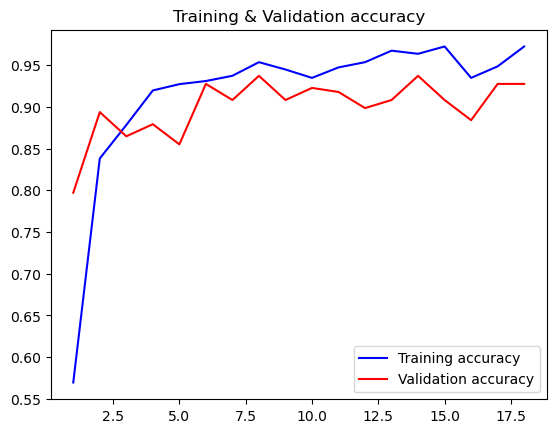

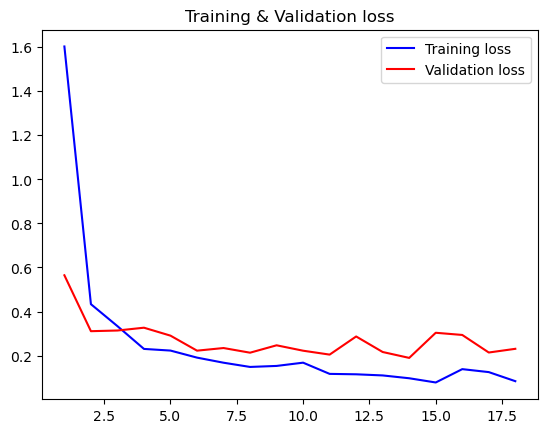

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.show()

In [14]:
# evaluate the model on unseen test data
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc*100}%')

Test Loss: 0.14085771143436432
Test Accuracy: 96.55172228813171%


In [15]:
print("[INFO] Saving model...")
save_path = './model.h5'
model.save(save_path)

[INFO] Saving model...


In [16]:
loaded_model= tensorflow.keras.models.load_model(save_path)

In [17]:
image_dir="D:\\KULIAH\\SKRIPSI\\Dataset\\PlantVillage\\Tomato_Late_blight\\0a3f65fc-ef1c-4aed-b235-46bae4e5c0e7___GHLB2 Leaf 9065.JPG"

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float32) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [18]:
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

1/1 [==============================] - 0s 384ms/step
probability:0.9996159
Tomato_Late_blight


4/4 [==============================] - 2s 556ms/step


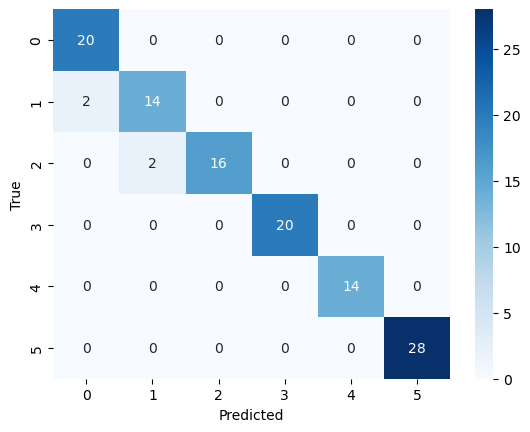

In [19]:
#Confusion Matrix
results=model.predict(X_test)
predicted_classes = np.argmax(results, axis=1)
true_classes = np.argmax(Y_test, axis=1)
confusion = confusion_matrix(true_classes, predicted_classes)

# create heatmap
sn.heatmap(confusion, annot=True, cmap='Blues', fmt='d')

# add x and y labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show plot
plt.show()

In [20]:
#Performance Metrics
acc = accuracy_score(true_classes, predicted_classes)
print(f'Test Accuracy: {acc*100}%')

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1 score: {f1}')

precision = precision_score(true_classes, predicted_classes, average='weighted')
print(f'Precision: {precision}')

recall = recall_score(true_classes, predicted_classes, average='weighted')
print(f'Recall: {recall}')

Test Accuracy: 96.55172413793103%
F1 score: 0.9654206510190283
Precision: 0.9670846394984326
Recall: 0.9655172413793104
